# Import Dependencies

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.10.1


# Pre-process Data

In [3]:
DATA_DIR = 'data/salt/'

In [4]:
cv_total = 5
cv_index = 1  # 0,1,2,3,4

In [5]:
version = 5
basic_name = f'unet_v2_{version}'
save_model_name = basic_name + 'A_cv' + str(cv_index) + '.model'
save_model_nameB = basic_name + 'B_cv' + str(cv_index) + '.model'
submission_file = basic_name + '_cv' + str(cv_index) + '.csv'

print(save_model_name)
print(save_model_nameB)
print(submission_file)

unet_v2_5A_cv1.model
unet_v2_5B_cv1.model
unet_v2_5_cv1.csv


In [6]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [7]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(f"{DATA_DIR}train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(f"{DATA_DIR}depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [8]:
train_df["images"] = [np.array(load_img(f"{DATA_DIR}train/images/{idx}.png", color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [9]:
train_df["masks"] = [np.array(load_img(f"{DATA_DIR}train/masks/{idx}.png", color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [10]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

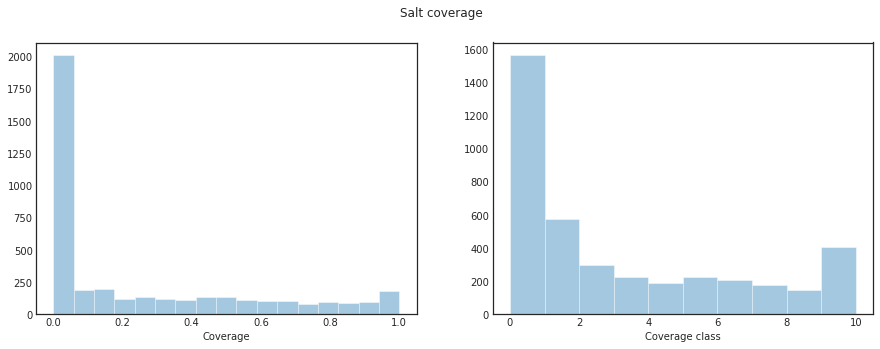

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

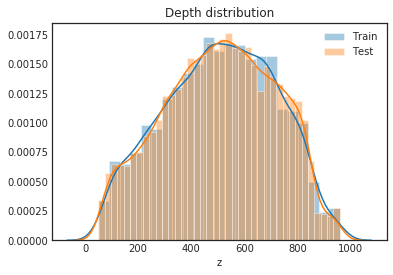

In [12]:
# Plotting the depth distributions

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Split Data

In [13]:
# # Create train/validation split stratified by salt coverage
# ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
# train_test_split(train_df.index.values, 
#                  np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
#                  np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
#                  train_df.coverage.values, 
#                  train_df.z.values, 
#                  test_size=0.2, stratify=train_df.coverage_class, random_state=555)

In [14]:
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=555, shuffle=True)

for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape, evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


In [15]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

In [16]:
x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)    

In [17]:
x_train[5,5,5]

array([0.38039216])

In [18]:
len(x_train), len(y_train)

(3199, 3199)

In [19]:
len(x_train), len(y_train)

(3199, 3199)

In [20]:
# boolean mask for mask with either all black pixel or at least 20 pixels
thres = 10
y_mask = np.squeeze((y_train.sum(axis=1).sum(axis=1)>=thres) | (y_train.sum(axis=1).sum(axis=1)==0))

In [21]:
# sample to remove
len(y_train)-y_mask.sum()

37

In [22]:
x_train = x_train[y_mask]
y_train = y_train[y_mask]

In [23]:
len(x_train), len(y_train)

(3162, 3162)

In [24]:
x_train_orig_len = len(x_train)
x_train_orig_len

3162

In [25]:
# only remove train, do not remove validation
len(x_valid), len(y_valid)

(801, 801)

# Data augmentation

In [26]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[0].grid(False)
    axarr[1].grid(False)
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

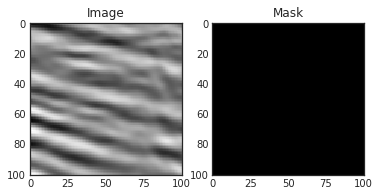

In [27]:
i = 21
plot2x2Array(x_train[i,:,:,0], y_train[i,:,:,0])

In [28]:
from imgaug import augmenters as iaa
import imgaug as ia

sometimes = lambda aug: iaa.Sometimes(0.9, aug)

In [29]:
affine_seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode= 'symmetric',
            pad_cval=(0, 1),
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # translate by -20 to +20 percent (per axis)
            shear=(-5, 5), # shear by -16 to +16 degrees
            cval=(0, 1), # if mode is constant, use a cval between 0 and 255
            mode='symmetric',
        )),
    
], random_order=True)

In [30]:
seq_det = affine_seq.to_deterministic()
aug_img = seq_det.augment_image(x_train[i,:,:])
aug_mask = seq_det.augment_image(y_train[i,:,:])

In [31]:
# plot2x2Array(x_train[i,:,:,0], aug_img[:,:,0])
# plot2x2Array(y_train[i,:,:,0], aug_mask[:,:,0])

In [32]:
aug_mask = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

In [33]:
np.unique(y_train[i,:,:,0])

array([0.])

In [34]:
np.unique(aug_mask)

array([0])

In [35]:
# plot2x2Array(y_train[i,:,:,0], aug_mask)

In [36]:
# x = x_train[21]
# y = y_train[21]
# print((x.shape),(y.shape))

# seq_det = affine_seq.to_deterministic()
# aug_img = seq_det.augment_image(x)
# aug_mask = seq_det.augment_image(y)
# aug_mask[:,:,0] = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

# print((aug_img.shape),(aug_mask.shape))
# plot2x2Array(x[:,:,0], y[:,:,0])

# plot2x2Array(aug_img[:,:,0], aug_mask[:,:,0])

In [37]:
# x_aug_list=[]
# y_aug_list=[]

# for x,y in tqdm_notebook(zip(x_train, y_train)):
#     seq_det = affine_seq.to_deterministic()
    
#     aug_img = seq_det.augment_image(x)
#     aug_mask = seq_det.augment_image(y)
#     aug_mask[:,:,0] = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

#     x_aug_list.append(aug_img)
#     y_aug_list.append(aug_mask)

In [38]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [39]:
# x_aug = np.array(x_aug_list)
# y_aug = np.array(y_aug_list)

In [40]:
# x_aug.shape

In [41]:
# x_train = np.append(x_train, x_aug, axis=0)
# y_train = np.append(y_train, y_aug, axis=0)

In [42]:
print(x_train.shape)
print(y_valid.shape)

(6324, 101, 101, 1)
(801, 101, 101, 1)


In [43]:
# i = 188
# plot2x2Array(x_train[i,:,:,0], y_train[i,:,:,0])

In [44]:
# plot2x2Array(x_train[i+x_train_orig_len,:,:,0], y_train[i+x_train_orig_len,:,:,0])

# Model Definitions

In [45]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [46]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Metric Loss

In [47]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [48]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

# Build Model

In [49]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

In [50]:
epochs = 300
batch_size = 64
c = optimizers.Adam(lr=0.001)

model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

# model1.summary()

In [51]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=21, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

In [52]:
%%time
history = model1.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 2)

Train on 6324 samples, validate on 801 samples
Epoch 1/300
 - 87s - loss: 0.3854 - my_iou_metric: 0.3317 - val_loss: 1.0417 - val_my_iou_metric: 0.1322

Epoch 00001: val_my_iou_metric improved from -inf to 0.13221, saving model to unet_v2_5A_cv1.model
Epoch 2/300
 - 73s - loss: 0.2909 - my_iou_metric: 0.5218 - val_loss: 0.9369 - val_my_iou_metric: 0.1789

Epoch 00002: val_my_iou_metric improved from 0.13221 to 0.17890, saving model to unet_v2_5A_cv1.model
Epoch 3/300
 - 72s - loss: 0.2494 - my_iou_metric: 0.5555 - val_loss: 0.4212 - val_my_iou_metric: 0.3589

Epoch 00003: val_my_iou_metric improved from 0.17890 to 0.35893, saving model to unet_v2_5A_cv1.model
Epoch 4/300
 - 72s - loss: 0.2206 - my_iou_metric: 0.6049 - val_loss: 0.3481 - val_my_iou_metric: 0.5213

Epoch 00004: val_my_iou_metric improved from 0.35893 to 0.52135, saving model to unet_v2_5A_cv1.model
Epoch 5/300
 - 72s - loss: 0.2083 - my_iou_metric: 0.6153 - val_loss: 0.8858 - val_my_iou_metric: 0.3240

Epoch 00005: val_m


Epoch 00045: val_my_iou_metric did not improve from 0.76941
Epoch 46/300
 - 71s - loss: 0.0650 - my_iou_metric: 0.8079 - val_loss: 0.2048 - val_my_iou_metric: 0.7643

Epoch 00046: val_my_iou_metric did not improve from 0.76941
Epoch 47/300
 - 71s - loss: 0.0660 - my_iou_metric: 0.8090 - val_loss: 0.1703 - val_my_iou_metric: 0.7571

Epoch 00047: val_my_iou_metric did not improve from 0.76941
Epoch 48/300
 - 71s - loss: 0.0620 - my_iou_metric: 0.8101 - val_loss: 0.1756 - val_my_iou_metric: 0.7705

Epoch 00048: val_my_iou_metric improved from 0.76941 to 0.77054, saving model to unet_v2_5A_cv1.model
Epoch 49/300
 - 71s - loss: 0.0660 - my_iou_metric: 0.8068 - val_loss: 0.1747 - val_my_iou_metric: 0.7627

Epoch 00049: val_my_iou_metric did not improve from 0.77054
Epoch 50/300
 - 72s - loss: 0.0628 - my_iou_metric: 0.8127 - val_loss: 0.1824 - val_my_iou_metric: 0.7674

Epoch 00050: val_my_iou_metric did not improve from 0.77054
Epoch 51/300
 - 72s - loss: 0.0618 - my_iou_metric: 0.8135 - v


Epoch 00091: val_my_iou_metric did not improve from 0.78652
Epoch 92/300
 - 71s - loss: 0.0453 - my_iou_metric: 0.8381 - val_loss: 0.2353 - val_my_iou_metric: 0.7845

Epoch 00092: val_my_iou_metric did not improve from 0.78652
Epoch 93/300
 - 71s - loss: 0.0452 - my_iou_metric: 0.8363 - val_loss: 0.2438 - val_my_iou_metric: 0.7824

Epoch 00093: val_my_iou_metric did not improve from 0.78652
Epoch 94/300
 - 71s - loss: 0.0437 - my_iou_metric: 0.8382 - val_loss: 0.2385 - val_my_iou_metric: 0.7843

Epoch 00094: val_my_iou_metric did not improve from 0.78652

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 95/300
 - 71s - loss: 0.0454 - my_iou_metric: 0.8369 - val_loss: 0.2357 - val_my_iou_metric: 0.7861

Epoch 00095: val_my_iou_metric did not improve from 0.78652
Epoch 96/300
 - 71s - loss: 0.0459 - my_iou_metric: 0.8370 - val_loss: 0.2286 - val_my_iou_metric: 0.7871

Epoch 00096: val_my_iou_metric improved from 0.78652 to 0.78714, saving model to u

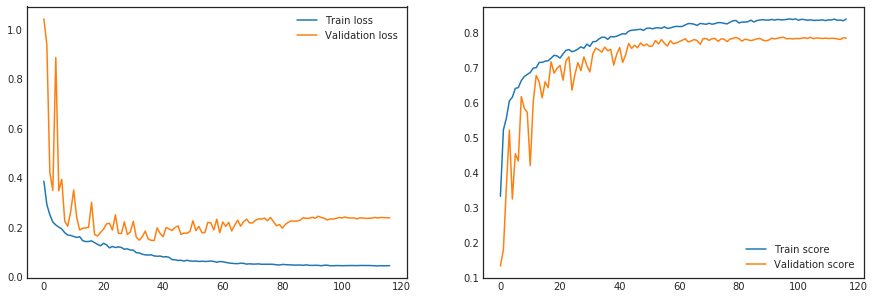

In [53]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

# Remove activation layer and use lovasz loss

In [55]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.0005)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

# model.summary()

In [51]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=21, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=7, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6324 samples, validate on 801 samples
Epoch 1/200
 - 210s - loss: -1.5224e-01 - my_iou_metric_2: 0.8108 - val_loss: 0.1595 - val_my_iou_metric_2: 0.7644

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.76442, saving model to unet_v2_5B_cv1.model
Epoch 2/200
 - 192s - loss: -2.0888e-01 - my_iou_metric_2: 0.8168 - val_loss: 0.0751 - val_my_iou_metric_2: 0.7507

Epoch 00002: val_my_iou_metric_2 did not improve from 0.76442
Epoch 3/200
 - 192s - loss: -2.2750e-01 - my_iou_metric_2: 0.8164 - val_loss: 0.0761 - val_my_iou_metric_2: 0.7795

Epoch 00003: val_my_iou_metric_2 improved from 0.76442 to 0.77953, saving model to unet_v2_5B_cv1.model
Epoch 4/200
 - 192s - loss: -2.2257e-01 - my_iou_metric_2: 0.8164 - val_loss: 0.0209 - val_my_iou_metric_2: 0.7805

Epoch 00004: val_my_iou_metric_2 improved from 0.77953 to 0.78052, saving model to unet_v2_5B_cv1.model
Epoch 5/200
 - 192s - loss: -2.4719e-01 - my_iou_metric_2: 0.8205 - val_loss: -1.1378e-02 - val_my_iou_metric_2: 0.768

# Plot result

In [50]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.adam(lr=0.0005)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

epochs = 200
batch_size = 32

In [51]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6324 samples, validate on 801 samples
Epoch 1/200
 - 207s - loss: -3.2373e-01 - my_iou_metric_2: 0.8332 - val_loss: 0.0874 - val_my_iou_metric_2: 0.7742

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.77416, saving model to unet_v2_5B_cv1.model
Epoch 2/200
 - 192s - loss: -2.9972e-01 - my_iou_metric_2: 0.8292 - val_loss: -5.1191e-03 - val_my_iou_metric_2: 0.7790

Epoch 00002: val_my_iou_metric_2 improved from 0.77416 to 0.77903, saving model to unet_v2_5B_cv1.model
Epoch 3/200
 - 192s - loss: -3.2810e-01 - my_iou_metric_2: 0.8330 - val_loss: 0.0113 - val_my_iou_metric_2: 0.7801

Epoch 00003: val_my_iou_metric_2 improved from 0.77903 to 0.78015, saving model to unet_v2_5B_cv1.model
Epoch 4/200
 - 192s - loss: -3.3205e-01 - my_iou_metric_2: 0.8354 - val_loss: 0.0756 - val_my_iou_metric_2: 0.7568

Epoch 00004: val_my_iou_metric_2 did not improve from 0.78015
Epoch 5/200
 - 192s - loss: -3.3950e-01 - my_iou_metric_2: 0.8366 - val_loss: 0.2242 - val_my_iou_metric_2: 0.764


Epoch 00042: val_my_iou_metric_2 did not improve from 0.81111
Epoch 43/200
 - 192s - loss: -5.7262e-01 - my_iou_metric_2: 0.8835 - val_loss: -4.1478e-03 - val_my_iou_metric_2: 0.8059

Epoch 00043: val_my_iou_metric_2 did not improve from 0.81111

Epoch 00043: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 44/200
 - 192s - loss: -5.6900e-01 - my_iou_metric_2: 0.8820 - val_loss: -1.2524e-02 - val_my_iou_metric_2: 0.8025

Epoch 00044: val_my_iou_metric_2 did not improve from 0.81111
Epoch 45/200
 - 192s - loss: -5.7307e-01 - my_iou_metric_2: 0.8836 - val_loss: -2.6597e-02 - val_my_iou_metric_2: 0.8031

Epoch 00045: val_my_iou_metric_2 did not improve from 0.81111
Epoch 46/200
 - 192s - loss: -5.6554e-01 - my_iou_metric_2: 0.8814 - val_loss: -2.2774e-02 - val_my_iou_metric_2: 0.8055

Epoch 00046: val_my_iou_metric_2 did not improve from 0.81111
Epoch 47/200
 - 192s - loss: -5.8219e-01 - my_iou_metric_2: 0.8841 - val_loss: -1.6971e-02 - val_my_iou_metric_2: 0.8061

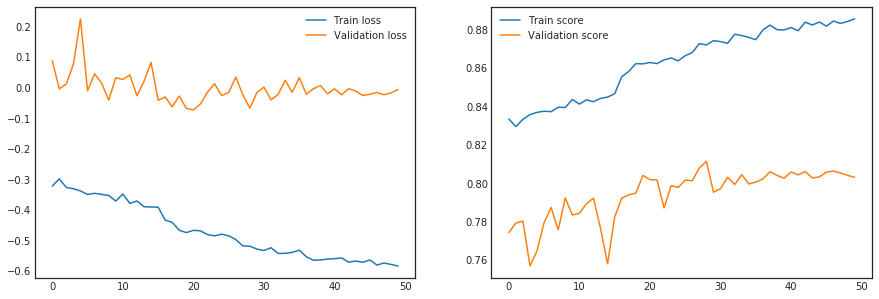

In [52]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [52]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.Adam(lr = 0.0001)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

epochs = 200
batch_size = 16

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6324 samples, validate on 801 samples
Epoch 1/200
 - 242s - loss: -4.6928e-01 - my_iou_metric_2: 0.8640 - val_loss: -1.3032e-02 - val_my_iou_metric_2: 0.8019

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.80187, saving model to unet_v2_5B_cv1.model
Epoch 2/200
 - 225s - loss: -4.8711e-01 - my_iou_metric_2: 0.8661 - val_loss: -6.4787e-02 - val_my_iou_metric_2: 0.7990

Epoch 00002: val_my_iou_metric_2 did not improve from 0.80187
Epoch 3/200
 - 225s - loss: -4.7622e-01 - my_iou_metric_2: 0.8651 - val_loss: -6.1823e-02 - val_my_iou_metric_2: 0.8067

Epoch 00003: val_my_iou_metric_2 improved from 0.80187 to 0.80674, saving model to unet_v2_5B_cv1.model
Epoch 4/200
 - 225s - loss: -4.7442e-01 - my_iou_metric_2: 0.8651 - val_loss: -4.4747e-02 - val_my_iou_metric_2: 0.8057

Epoch 00004: val_my_iou_metric_2 did not improve from 0.80674
Epoch 5/200
 - 225s - loss: -4.9356e-01 - my_iou_metric_2: 0.8671 - val_loss: -4.4353e-02 - val_my_iou_metric_2: 0.8045

Epoch 00005: val_my

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [49]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [50]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [51]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [52]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [53]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.80586767 0.80636704 0.80661673 0.80699126 0.8071161  0.80774032
 0.80799001 0.8071161  0.80736579 0.80724095 0.80724095 0.80886392
 0.80923845 0.80898876 0.80998752 0.80948814 0.80948814 0.80898876
 0.80923845 0.80998752 0.8093633  0.81273408 0.81161049 0.81123596
 0.81048689 0.8102372  0.81073658 0.81048689 0.80986267 0.80898876
 0.80774032]


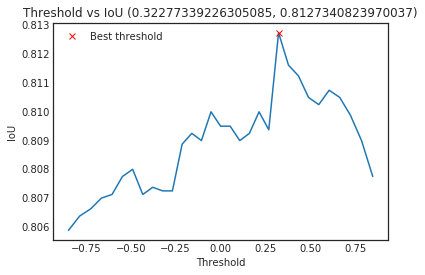

In [54]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [55]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [57]:
x_test = np.array([(np.array(load_img(f"{DATA_DIR}test/images/{idx}.png", color_mode='grayscale'))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [58]:
preds_test = predict_result(model,x_test,img_size_target)

In [59]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [60]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [61]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 0.08618407196468778 hours
